Import relevant packages

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

Set up data loading functions.

In [ ]:
tf.__version__
seed = 18
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(random)

Load data.

In [ ]:
names = []

with os.scandir('training/') as entries:
    for entry in entries:
        names.append("training/"+entry.name)

#with os.scandir('test/') as entries:
#    for entry in entries:
#        names.append("test/"+entry.name)

In [ ]:
def load(name):
    X = []
    Y = []
    with open(name) as json_file:
        data = json.load(json_file) 
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY[:, :, 0] = coutr
            #! Clone?
            cY[:, :, 1] = coutr
            X.append(cX)
            Y.append(cY)
            
        for t in data['test']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY[:, :, 0] = coutr
            #! Clone?
            cY[:, :, 1] = coutr
            
            X.append(cX)
            Y.append(cY)

    return [np.array(X), np.array(Y)]

In [63]:
import matplotlib.pyplot as plt

def plot(inp):
    plt.imshow(inp[:, :, 0].reshape(30, 30))
    plt.colorbar()
    plt.show()

In [ ]:
def loss_f(x, y):
    return tf.reduce_mean(tf.square(x[:, :, :, 0]-y[:, :, :, 0]))

In [74]:
def train(model, ctask, epochs, iterations, channels, verbose=False, validate=False, wholetask=None):
    trainer = tf.keras.optimizers.Adam()

    origx = ctask[0]
    x = origx.copy()
    y = ctask[1]

    mask = np.zeros((x.shape[0], 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = origx*mask

    for k in range(epochs):
        x = origx.copy()
        with tf.GradientTape() as g:
            for i in tf.range(iterations):
                x = model(x)
                x = x*(1-mask)+xl2
            loss = loss_f(x, y)
            grads = g.gradient(loss, model.weights)
            #grads = [g/(tf.norm(g)+1e-8) for g in grads]
            trainer.apply_gradients(zip(grads, model.weights))
        if k%5 == 0:
            generated = np.clip(np.round(generate(model, wholetask[0], channels, iterations)), -1, 9)
            groundtruth = wholetask[1]
            valacc = testacc(generated, groundtruth)
            if verbose:
                plot(generated[1])
                print("LOSS AT EPOCH "+str(k)+": "+str(loss.numpy())+" TRAIN ACCURACY: "+str(np.sum(valacc[0:-1]))+" VALIDATION ACCURACY: "+str(valacc[-1]))
    return model

In [75]:
def generate(model, cin, channels, iterations):
    mask = np.zeros((cin.shape[0], 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = cin*mask
    
    for i in range(iterations):
        cin = model(cin)
        cin = cin*(1-mask)+xl2
        if i%10 == 0:
            pass
            #toprint = cin.numpy()[0]
            #plot(toprint)
    
    toprint = cin.numpy()
    return toprint

In [54]:
def testacc(generated, groundtruth):
    print(generated.shape)
    generated = generated[:, :, :, 0]
    groundtruth = groundtruth[:, :, :, 0]
    same = (generated==groundtruth).astype(int)
    mask = (groundtruth != -1).astype(int)
    same *= mask
    same = np.sum(same, axis=(1, 2))
    print(same, np.count_nonzero(mask, axis=(1, 2)))
    same = same/np.count_nonzero(mask, axis=(1, 2))
    return same

In [34]:
tf.get_logger().setLevel('ERROR')
def test(ntasks, channels, filters, perceptionsize, neurons, epochs, iterations, plotting):
    tasks = random.sample(names, k=ntasks)
    avgacc = 0
    i = 0
    for task in tasks:
        i += 1
        model = tf.keras.Sequential([
            tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
            tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
            tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        ctask = load(task)
        cin = [ctask[0][0:-1], ctask[1][0:-1]]
        ctest = [ctask[0][-1], ctask[1][-1]]
        model = train(model, cin, epochs, iterations, channels, False, False, ctask)
        generated = np.clip(np.round(generate(model, np.array([ctest[0]]), channels, iterations)), -1, 9)
        groundtruth = ctest[1]
        if plotting:
            plot(generated)
            plot(groundtruth)
        acc = testacc(generated, groundtruth)
        avgacc += acc
        print("CURRENT ACCURACY "+str((acc*100)))
    avgacc /= ntasks
    return avgacc

In [ ]:
ntasks = 5
channels = 18
filters = 3
perceptionsize = 3
neurons = 128
epochs = 100
iterations = 200

model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

ctask = load(names[104])
cin = [ctask[0][0:-1], ctask[1][0:-1]]
ctest = [ctask[0][-1], ctask[1][-1]]
plot(ctest[0])
plot(ctest[1])
model = train(model, cin, epochs, iterations, channels, True, True, ctest)

In [ ]:
ntasks = 5
channels = 20
filters = 10
perceptionsize = 3
neurons = 128
epochs = 20
iterations = 100

'''THIS WORKS
ntasks = 5
channels = 20
filters = 10
perceptionsize = 3
neurons = 200
epochs = 700
iterations = 100
'''

ranges = {"channels": [5, 70], "filters": [1, 20], "perceptionsize": [3, 7], "neurons": [20, 700], "epochs": [50, 700], "iterations":  [100, 1000]}

cacc = test(ntasks, channels, filters, perceptionsize, neurons, epochs, iterations, True)
print(cacc*100)

4


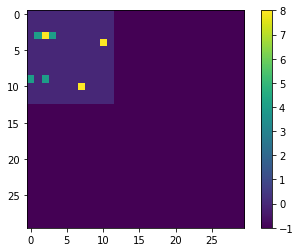

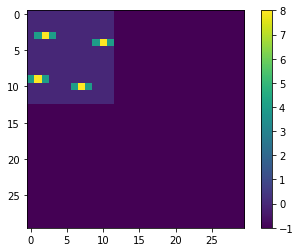

In [ ]:
ntasks = 5
channels = 8
filters = 20
perceptionsize = 3
neurons = 128
epochs = 300
iterations = 100

model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])
task = names[257]
ctask = load(task)
print(len(ctask[0]))
plot(ctask[0][1])
plot(ctask[1][1])
cin = [ctask[0][0:-1], ctask[1][0:-1]]
model = train(model, cin, epochs, iterations, channels, True, True, ctask)

Define model.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((3, 3), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(128, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

In [ ]:
current = 10

ctask = load(names[current])
plot(ctask[0][0])
plot(ctask[1][0])

In [ ]:
plot(np.clip(np.round(out), -1, 9))
plot(ctask[1][1])

In [ ]:
testacc(np.clip(np.round(out), -1, 9), ctask[1][1])